# Compare the regression of the base model with the pollutant validation dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df_pollu = df.copy()

In [4]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [5]:
df_final = df_final.dropna()

In [6]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)


df_train = df_final[train_mask]
df_val = df_final[val_mask]


print(f"Training set size: {df_train.count()} rows")
print(f"Validation set size: {df_val.count()} rows")
print(f"Training set date range: {df_train['Date'].min()} to {df_train['Date'].max()}")
print(f"Validation set date range: {df_val['Date'].min()} to {df_val['Date'].max()}")

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

Training set size: Date            1461
DayOfWeekNum    1461
WeekOfYear      1461
Month           1461
IsWeekend       1461
IsHoliday       1461
NUMBER_INT      1461
temp_max        1461
temp_min        1461
humidity_max    1461
dtype: int64 rows
Validation set size: Date            360
DayOfWeekNum    360
WeekOfYear      360
Month           360
IsWeekend       360
IsHoliday       360
NUMBER_INT      360
temp_max        360
temp_min        360
humidity_max    360
dtype: int64 rows
Training set date range: 2015-01-01 00:00:00 to 2018-12-31 00:00:00
Validation set date range: 2019-01-01 00:00:00 to 2019-12-26 00:00:00


In [7]:
results = []
results30 = []

In [8]:

best_rf_model_base = RandomForestRegressor(
    n_estimators=60,
    max_depth=6,
    min_samples_split=14,
    random_state=3
)

best_rf_model_base.fit(X_train, y_train)


y_pred = best_rf_model_base.predict(X_val)

# Metrics 1y
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mape_val = mape(y_val, y_pred)
smape_val = smape(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr = np.corrcoef(y_val, y_pred)[0, 1]

# Metrics 30d
y_pred_30d = best_rf_model_base.predict(X_val[:30])
y_val_30 = y_val[:30]
mse_30d = mean_squared_error(y_val_30, y_pred_30d)
rmse_30d = np.sqrt(mse_30d)
mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
mape_val_30d = mape(y_val_30, y_pred_30d)
smape_val_30d = smape(y_val_30, y_pred_30d)
r2_30d = r2_score(y_val_30, y_pred_30d)
corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

results.append({
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape_val,
    'sMAPE': smape_val,
    'R2': r2,
    'Correlation': corr
})

results30.append({
    'run': 1,
    'random_state': 0,
    'MSE_30d': mse_30d,
    'RMSE_30d': rmse_30d,
    'MAE_30d': mae_30d,
    'MAPE_30d': mape_val_30d,
    'sMAPE_30d': smape_val_30d,
    'R2_30d': r2_30d,
    'Correlation_30d': corr_30d
})

In [9]:
pd.DataFrame(results)


,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation
0,119.175146,10.916737,8.140134,15.423293,16.472651,0.501489,0.785279


In [10]:
pd.DataFrame(results30)

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,63.569613,7.973055,6.690935,16.921514,18.594293,0.050586,0.674274


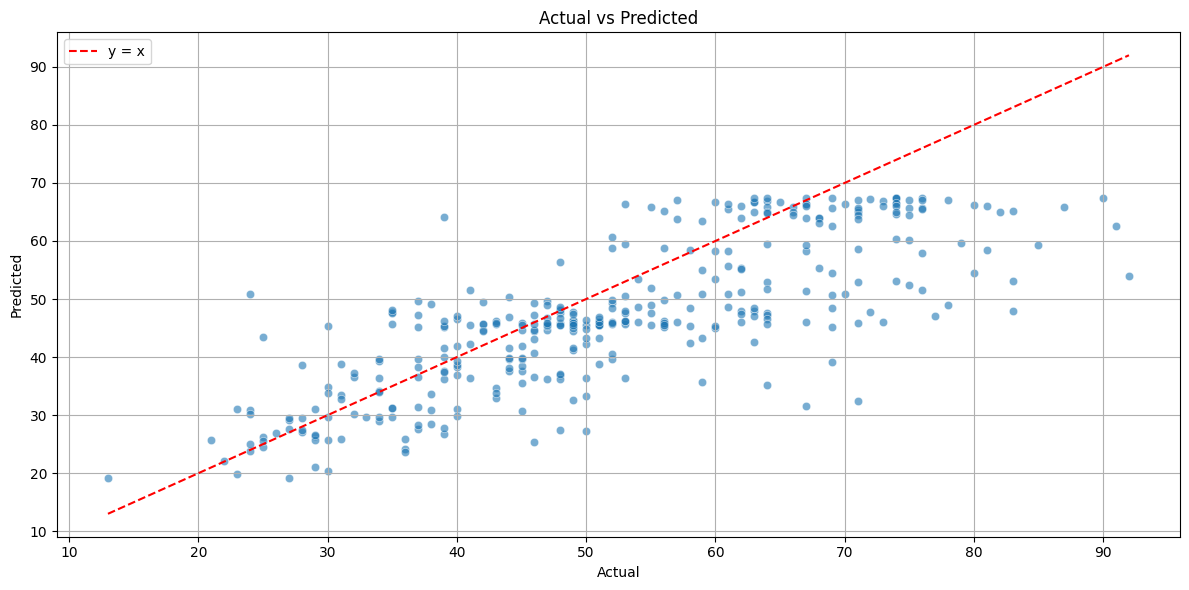

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

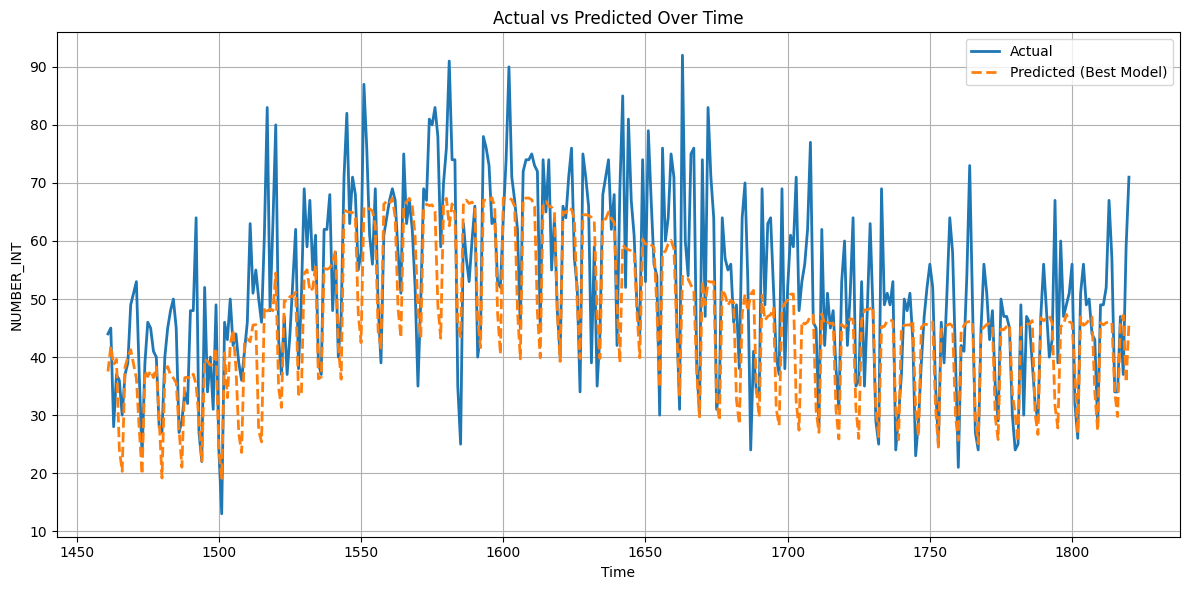

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

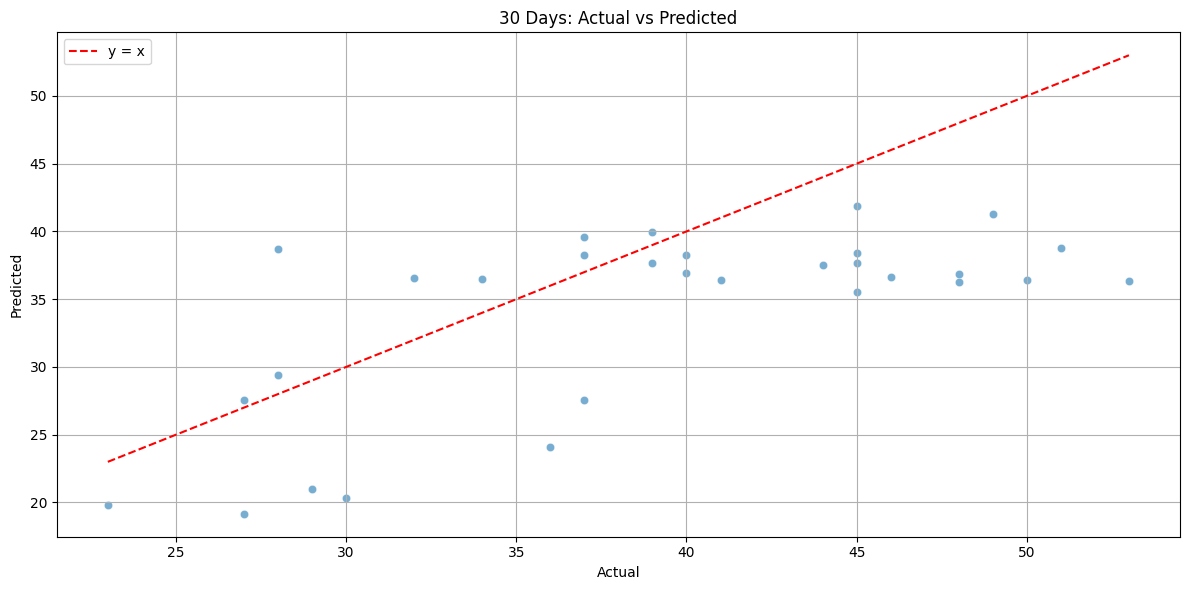

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


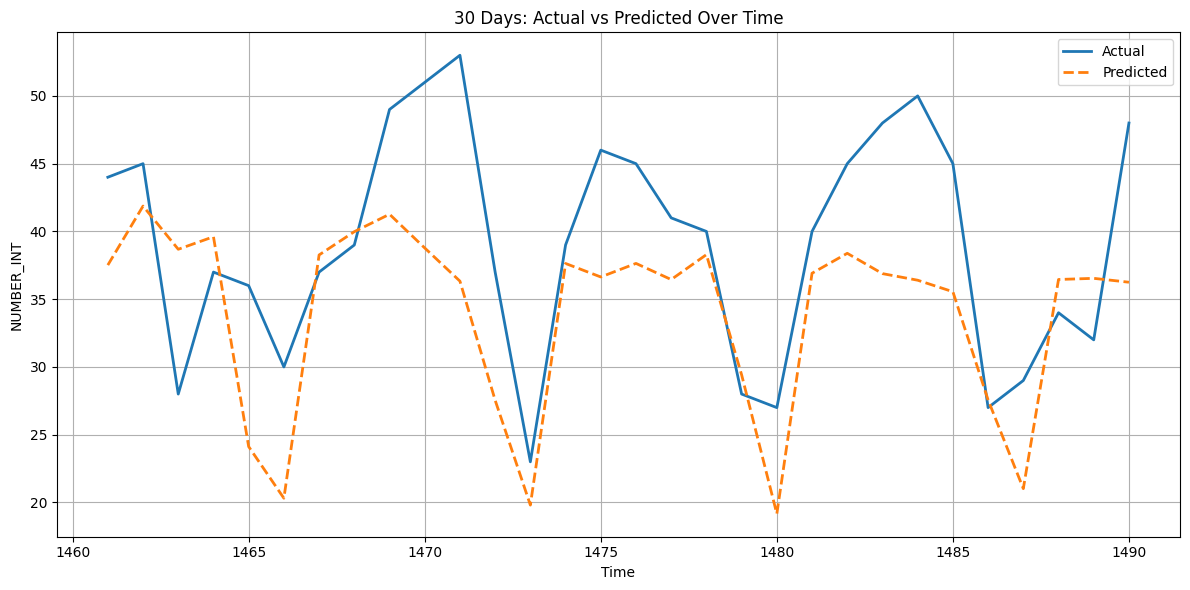

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# With pollutant

In [15]:
selected_cols_final_pollu = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'O3',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_pollu_final = df_pollu[selected_cols_final_pollu].copy()

# add lag

df_pollu_final['O3_lag1'] = df_pollu_final['O3'].shift(1)
df_pollu_final['O3_lag2'] = df_pollu_final['O3'].shift(2)
df_pollu_final['O3_lag3'] = df_pollu_final['O3'].shift(3)

df_pollu_final['temp_min_lag1'] = df_pollu_final['temp_min'].shift(1)
df_pollu_final['temp_min_lag2'] = df_pollu_final['temp_min'].shift(2)
df_pollu_final['temp_min_lag3'] = df_pollu_final['temp_min'].shift(3)

# df_pollu_final['humidity_max_lag1'] = df_pollu_final['humidity_max'].shift(1)
# df_pollu_final['humidity_max_lag2'] = df_pollu_final['humidity_max'].shift(2)
# df_pollu_final['humidity_max_lag3'] = df_pollu_final['humidity_max'].shift(3)

df_pollu_final = df_pollu_final.dropna()
df_pollu_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1155 entries, 3 to 1677
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1155 non-null   object 
 1   DayOfWeekNum   1155 non-null   int64  
 2   WeekOfYear     1155 non-null   int64  
 3   Month          1155 non-null   int64  
 4   IsWeekend      1155 non-null   int64  
 5   IsHoliday      1155 non-null   int64  
 6   NUMBER_INT     1155 non-null   int64  
 7   O3             1155 non-null   float64
 8   temp_max       1155 non-null   float64
 9   temp_min       1155 non-null   float64
 10  humidity_max   1155 non-null   float64
 11  O3_lag1        1155 non-null   float64
 12  O3_lag2        1155 non-null   float64
 13  O3_lag3        1155 non-null   float64
 14  temp_min_lag1  1155 non-null   float64
 15  temp_min_lag2  1155 non-null   float64
 16  temp_min_lag3  1155 non-null   float64
dtypes: float64(10), int64(6), object(1)
memory usage: 162.4+ 

In [16]:
df_pollu_final['Date'] = pd.to_datetime(df_pollu_final['Date'])

# remove the last 5 days (account for lag ...)
# df_pollu_final = df_pollu_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
val_mask_pollu = df_pollu_final['Date'].dt.year == (min_year + 4)


df_pollu_val = df_pollu_final[val_mask_pollu]
df_pollu_val = df_pollu_val.drop(columns=['Date'])

X = df_pollu_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_pollu_final['NUMBER_INT']


In [17]:
# TODO
# Drop the columns that are not needed for test

X_val = df_pollu_val.drop(columns=['NUMBER_INT', 'O3', 'O3_lag1', 'O3_lag2', 'O3_lag3', 
                                   'temp_min_lag1', 'temp_min_lag2', 'temp_min_lag3'])
y_val = df_pollu_val['NUMBER_INT']


results_pollu = []


# Count Val set
X_val.count()

DayOfWeekNum    101
WeekOfYear      101
Month           101
IsWeekend       101
IsHoliday       101
temp_max        101
temp_min        101
humidity_max    101
dtype: int64

In [18]:
y_predi_pollut = best_rf_model_base.predict(X_val)

# Metrics 1y
mse = mean_squared_error(y_val, y_predi_pollut)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_predi_pollut)
mape_val = mape(y_val, y_predi_pollut)
smape_val = smape(y_val, y_predi_pollut)
r2 = r2_score(y_val, y_predi_pollut)
corr = np.corrcoef(y_val, y_predi_pollut)[0, 1]


results_pollu.append({
'MSE': mse,
'RMSE': rmse,
'MAE': mae,
'MAPE': mape_val,
'sMAPE': smape_val,
'R2': r2,
'Correlation': corr,
})



In [19]:
pd.DataFrame(results_pollu)

,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation
0,138.593265,11.772564,8.976781,15.661901,17.127371,0.526811,0.824325


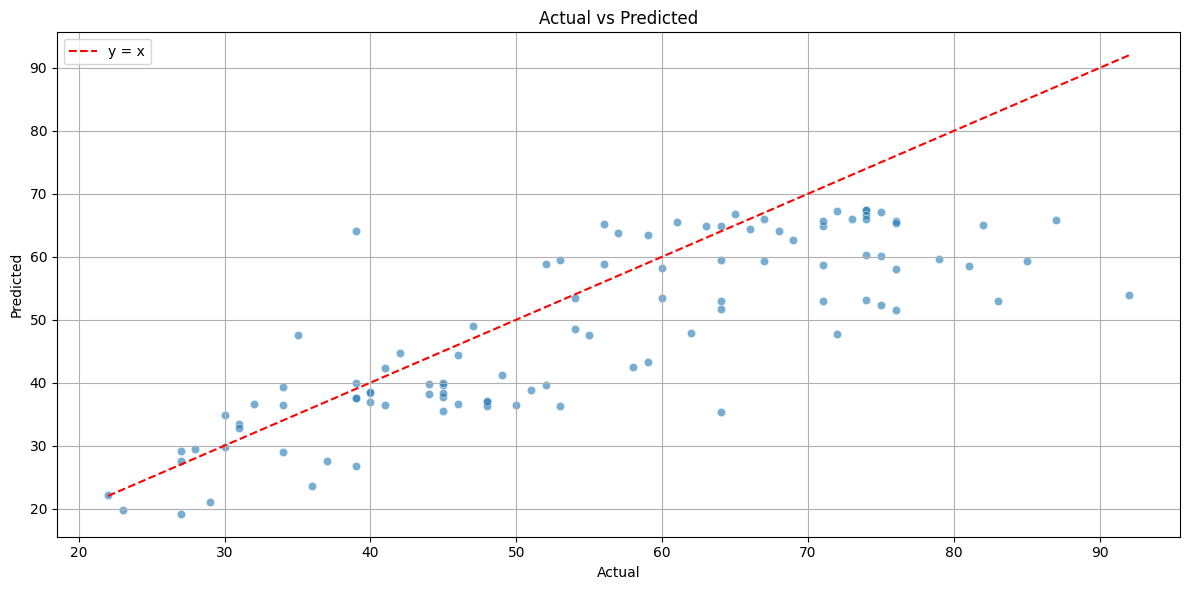

In [20]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_predi_pollut, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

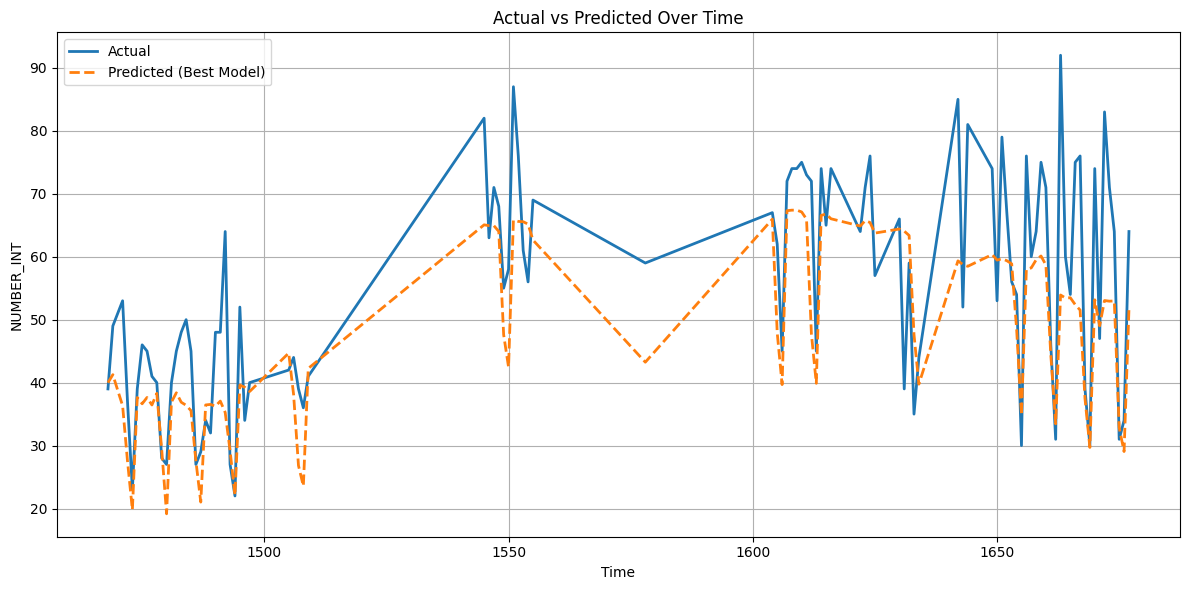

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_predi_pollut, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()